# Importing necessary Libraries

In [7]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from gensim.models import Word2Vec, KeyedVectors
from gensim.utils import simple_preprocess
from sklearn.metrics.pairwise import cosine_similarity
import gensim.downloader as api
import os

In [9]:
books = pd.read_csv("../data/Books.csv")
users = pd.read_csv("../data/Users.csv")
ratings = pd.read_csv("../data/Ratings.csv")

C:\Users\shefa\AppData\Local\Temp\ipykernel_20772\4173770096.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv("../data/Books.csv")


In [5]:
books.describe()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
count,271360,271360,271358,271360,271358,271360,271360,271357
unique,271360,242135,102022,202,16807,271044,271044,271041
top,0195153448,Selected Poems,Agatha Christie,2002,Harlequin,http://images.amazon.com/images/P/185326119X.0...,http://images.amazon.com/images/P/185326119X.0...,http://images.amazon.com/images/P/225307649X.0...
freq,1,27,632,13903,7535,2,2,2


# Data cleaning and exploratory data analysis

In [21]:
# Merge and create a single dataset with books and user ratings
df = pd.merge(ratings, books, on='ISBN', how='left')

In [22]:
# Drop unnecessary columns (URLS)
df = df.drop(columns=["Image-URL-S", "Image-URL-M", "Image-URL-L"], axis=1)

In [9]:
# Check unique count and data type of each column 
for col in df.columns:
    unique_counts = df[col].nunique()
    data_type = df[col].dtype
    print(f"Column: {col}, Count: {unique_counts}, Data Type: {data_type}")

Column: User-ID, Count: 105283, Data Type: int64
Column: ISBN, Count: 340556, Data Type: object
Column: Book-Rating, Count: 11, Data Type: int64
Column: Book-Title, Count: 241071, Data Type: object
Column: Book-Author, Count: 101587, Data Type: object
Column: Year-Of-Publication, Count: 202, Data Type: object
Column: Publisher, Count: 16729, Data Type: object


In [10]:
df.isnull().sum()

User-ID                     0
ISBN                        0
Book-Rating                 0
Book-Title             118644
Book-Author            118646
Year-Of-Publication    118644
Publisher              118646
dtype: int64

In [13]:
# As approx. 10% values are missing, we will drop them from the dataset for now. Imputation is not possible in this case as book's publisher name, author etc. are unique to each book.
df = df.dropna()

In [14]:
# Lastly, we change the names to lowercase (not necessary but helpful later)
df.columns = df.columns.str.lower()
df

,user-id,isbn,book-rating,book-title,book-author,year-of-publication,publisher
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
1,276726,0155061224,5,Rites of Passage,Judith Rae,2001,Heinle
2,276727,0446520802,0,The Notebook,Nicholas Sparks,1996,Warner Books
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999,Cambridge University Press
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press
...,...,...,...,...,...,...,...
1149774,276704,0876044011,0,Edgar Cayce on the Akashic Records: The Book o...,Kevin J. Todeschi,1998,A.R.E. Press (Association of Research &amp; Enlig
1149775,276704,1563526298,9,Get Clark Smart : The Ultimate Guide for the S...,Clark Howard,2000,Longstreet Press
1149776,276706,0679447156,0,Eight Weeks to Optimum Health: A Proven Progra...,Andrew Weil,1997,Alfred A. Knopf
1149777,276709,0515107662,10,The Sherbrooke Bride (Bride Trilogy (Paperback)),Catherine Coulter,1996,Jove Books


In [13]:
# import pandas as pd
# import requests
# from PIL import Image
# from io import BytesIO
# import re

# # Assuming df is your DataFrame and 'image-url-m' is the column containing image URLs
# # Replace 'df' and 'image-url-m' with your actual DataFrame and column name
# headers = {
#     'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
# }
# for index, row in books[10115:].iterrows():
    
#         image_url = row['Image-URL-L']
#         response = requests.get(image_url, headers=headers)
#         if response.status_code == 200:
#             # Open the image from the URL
#             img = Image.open(BytesIO(response.content))
            
#             # Get the book title from the column 'book-title'
#             book_title = row['Book-Title']
#             book_title = book_title.replace(" ", "_")
#             book_title = re.sub(r'\W+', '', book_title)
#             img = img.convert('RGB')
#             # Save the image as a PNG file with the book title as the file name
#             img.save(f"../lib/www/{book_title}.jpg", "JPEG")
#         else:
#             print(f"Failed to download image for index {index}")
#         print(index)

# # This code iterates through each row in the DataFrame, downloads the image from the URL,
# # and saves it as a PNG file with the book title as the file name.


In [14]:
# import pandas as pd
# import requests
# from PIL import Image
# from io import BytesIO
# import re
# import os

# # Assuming df is your DataFrame and 'image-url-m' is the column containing image URLs
# # Replace 'df' and 'image-url-m' with your actual DataFrame and column name
# headers = {
#     'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
# }
# for index, row in books.iterrows():
    
#         # image_url = row['Image-URL-L']
#         # # response = requests.get(image_url, headers=headers)
#         # if response.status_code == 200:
#         #     # Open the image from the URL
#         #     img = Image.open(BytesIO(response.content))
            
#             # Get the book title from the column 'book-title'
#         book_title = row['Book-Title']
#         book_title = book_title.replace(" ", "_")
#         book_title = re.sub(r'\W+', '', book_title)
#             # img = img.convert('RGB')
#             # Save the image as a PNG file with the book title as the file name
#         if os.path.exists(f"../lib/www/{book_title}.jpg"):
#             continue
#             # img.save(f"../lib/www/{book_title}.jpg", "JPEG")
#         else:
#             print(f"Failed to download image for index {index}")
#         # print(index)

# # This code iterates through each row in the DataFrame, downloads the image from the URL,
# # and saves it as a PNG file with the book title as the file name.


In [15]:
# import os
# import requests
# from PIL import Image
# from io import BytesIO
# import re

# def get_book_image(book_title, books_dataframe):
#     # Clean the book title
#     cleaned_title = book_title.replace(" ", "_")
#     cleaned_title = re.sub(r'\W+', '', cleaned_title)
    
#     # Check if the image exists in the folder
#     file_path = os.path.join(f"../lib/www/{cleaned_title}.jpg")
#     if os.path.exists(file_path):
#         return file_path
    
#     # If image not found in the folder, find URL from DataFrame and download
#     book_row = books_dataframe[books_dataframe['Book-Title'] == book_title]
#     if not book_row.empty:
#         image_url = book_row.iloc[0]['Image-URL-L']
#         headers = {
#             'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
#         }
#         response = requests.get(image_url, headers=headers)
#         if response.status_code == 200:
#             img = Image.open(BytesIO(response.content))
#             img = img.convert('RGB')
#             img.save(file_path, "JPEG")
#             return file_path
#         else:
#             print(f"Failed to download image for '{book_title}'")
#     else:
#         print(f"Book '{book_title}' not found in the DataFrame")
    
#     return None

# # Usage example:
# book_title_input = "Harry Potter and the Prisoner of Azkaban"  # Replace this with the desired book title
# books_dataframe_input = books  # Replace this with your DataFrame

# image = get_book_image(book_title_input, books_dataframe_input)
# print(image) # Display the downloaded or existing image


In [19]:
# Set palette
sns.set_palette("pastel6")

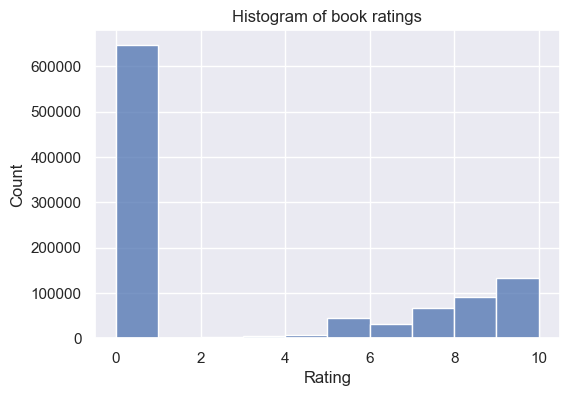

In [17]:
# Histogram of book-ratings
sns.set(rc = {'figure.figsize':(6,4)}) # reset dimensions of the plot
plot1 = sns.histplot(data=df, x="book-rating", bins=10)
plot1.set_title('Histogram of book ratings')
plot1.set_xlabel('Rating', fontsize=12)
plot1.set_ylabel('Count', fontsize=12)

plt.show()

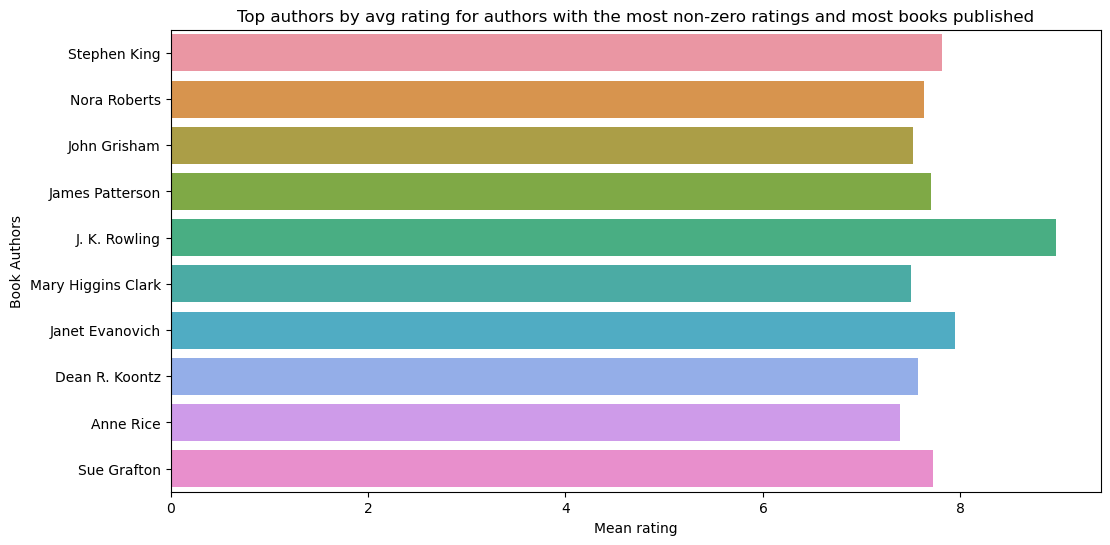

In [20]:
# Filter out authors with zero ratings (no ratings given)
filtered_df = df[df['book-rating'] > 0]
grouped_authors = filtered_df.groupby('book-author')['book-rating'].agg(['mean', 'count'])
# Identify authors with the most number of non-zero ratings
top_authors = grouped_authors['count'].nlargest(10).index
# Include only the top authors
filtered_df = filtered_df[filtered_df['book-author'].isin(top_authors)]
# Sort authors by the number of books published
sorted_authors = filtered_df['book-author'].value_counts().index

avg_ratings = filtered_df.groupby('book-author')['book-rating'].mean().loc[sorted_authors]

plt.figure(figsize=(12, 6))
sns.barplot(x=avg_ratings.values, y=avg_ratings.index)
plt.title('Top authors by avg rating for authors with the most non-zero ratings and most books published')
plt.xlabel('Mean rating')
plt.ylabel('Book Authors')
plt.show()

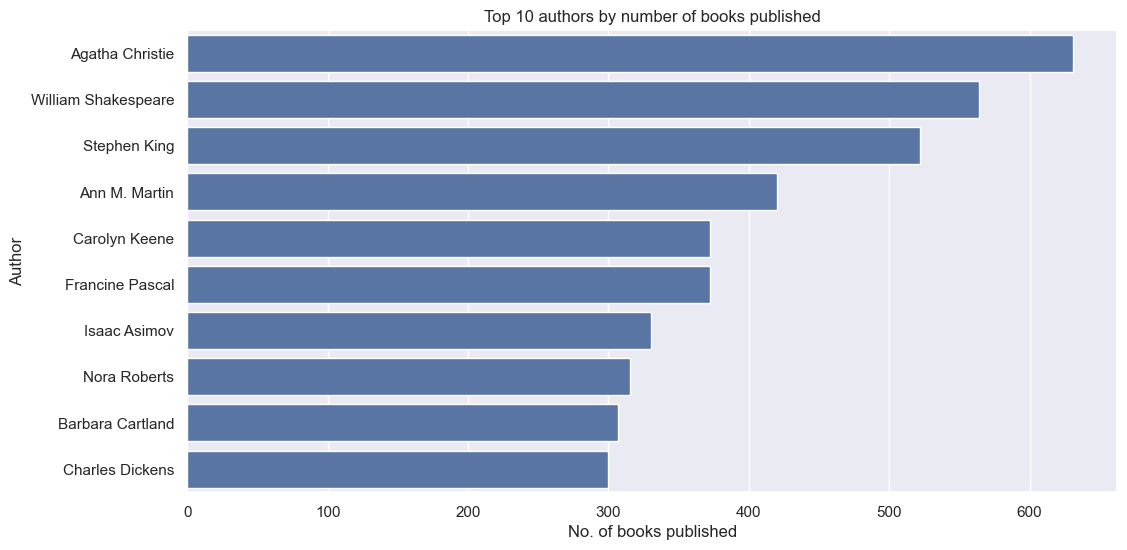

In [19]:
# Top 10 authors by number of books published
books_by_authors = df.groupby('book-author')['isbn'].nunique()

# Get the top 10 authors based on the number of books published
top_10_authors = books_by_authors.sort_values(ascending=False).head(10)

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_authors.values, y=top_10_authors.index)
plt.title('Top 10 authors by number of books published')
plt.xlabel('No. of books published')
plt.ylabel('Author')

plt.show()

# Feature scaling and preparation for model

In [20]:
duplicates = df[df.duplicated('isbn')].sort_values('isbn', ascending=False)
duplicates[5:10]

## Each book has multiple user ratings mapped to it. 

,user-id,isbn,book-rating,book-title,book-author,year-of-publication,publisher
1006798,241791,B0000VZEH8,9,Back Roads,Tawni O'Dell,2000,Viking Press
468744,112001,B0000T6KHI,10,Three Fates,Nora Roberts,2002,Putnam Pub Group
864888,209160,B0000E63CJ,0,Dreamcatcher,Stephen King,2001,Scribner
991510,238475,B0000E63CJ,0,Dreamcatcher,Stephen King,2001,Scribner
680073,165512,B0000E63CJ,8,Dreamcatcher,Stephen King,2001,Scribner


In [21]:
# Content based filtering
# To avoid duplicate recommendations, we'll remove duplicates from the dataframe
books_new = df.drop_duplicates(subset=['isbn'])
books_new = df.drop_duplicates(subset=['book-title'])

In [22]:
books_new

,user-id,isbn,book-rating,book-title,book-author,year-of-publication,publisher
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
1,276726,0155061224,5,Rites of Passage,Judith Rae,2001,Heinle
2,276727,0446520802,0,The Notebook,Nicholas Sparks,1996,Warner Books
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999,Cambridge University Press
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press
...,...,...,...,...,...,...,...
1149689,276688,0425150526,0,Death Crosses the Border,Janice Steinberg,1995,Berkley Publishing Group
1149698,276688,0449907422,0,Jazz Funeral: A Skip Langdon Novel,Julie Smith,1993,Ballantine Books
1149757,276690,0590907301,0,Triplet Trouble and the Class Trip (Triplet Tr...,Debbie Dadey,1997,Apple
1149770,276704,0679752714,0,A Desert of Pure Feeling (Vintage Contemporaries),Judith Freeman,1997,Vintage Books USA


In [23]:
# Remove duplicates

duplicate_titles = books_new[books_new.duplicated(subset=['book-title'], keep=False)]
print(duplicate_titles[['book-title']])

Empty DataFrame
Columns: [book-title]
Index: []


In [24]:
# Convert year to string for concatanation in next step# Create a copy of the DataFrame to avoid SettingWithCopyWarning
books_new = books_new.copy()

# Convert 'year-of-publication' to string
books_new['year-of-publication'] = books_new['year-of-publication'].astype(str)

In [25]:
# Create a single feature
books_new['content'] = books_new['book-title'] + ' ' + books_new['book-author'] + '' + books_new['year-of-publication']
books_new['content'] = books_new['content'].fillna('')

# Content-based filtering

In [26]:
# Tokenize for word2vec
books_new['tokenized_content'] = books_new['content'].apply(simple_preprocess)

In [27]:
model = api.load('word2vec-google-news-300')

In [28]:
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector

In [29]:
# Function to compute average word vectors for all books
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.index_to_key)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features) for tokenized_sentence in corpus]
    return np.array(features)

In [30]:
# Compute average word vectors for all books
w2v_feature_array = averaged_word_vectorizer(corpus=books_new['tokenized_content'], model=model, num_features=300)

# 

In [31]:
user_book = "Harry Potter and the Prisoner of Azkaban"

In [32]:
# Find the index of the user's movie
book_index = books_new[books_new['book-title'] == user_book].index[0]

In [33]:
user_book_vector = w2v_feature_array[book_index].reshape(1, -1)
similarity_scores = cosine_similarity(user_book_vector, w2v_feature_array)

In [34]:
# Get the top 10 most similar books
similar_books = list(enumerate(similarity_scores[0]))
sorted_similar_books = sorted(similar_books, key=lambda x: x[1], reverse=True)[1:20]

#

In [35]:
user_book

'Harry Potter and the Prisoner of Azkaban'

In [36]:
for i, score in sorted_similar_books:
    print("{}: {}".format(i, books_new.iloc[i]['book-title']))


134409: Lost Light: A Novel
27679: Lost World
158642: SOUTH LIGHT
2579: The Lost World
135656: Lorien Lost
93023: Dark Spectre
13865: Brideshead Regained
22338: The Narrowback
136315: The Thornbush
142655: The Undine
163520: The Caddie
199940: Little Lost Fievel (An American Tail)
218431: Lost Classics
112910: The Widowmaker
9118: Gloriana
9812: Summerland
16668: Sunstrike
32341: Schwarze TrÃ?Â¼ffel.
34371: Tularosa


In [22]:
for i in range(3,10):
    print(f"""
@output
    @render.image
    def image{i}():
        if len(input.txt())==0:
            user_book = "The Notebook"
        else:
            user_book = input.txt()
        sorted_similar_book_titles = get_recommendations(user_book)
        book_title = sorted_similar_book_titles[{i-1}]
        img_src = get_book_image(book_title)
        img: ImgData = {"src" "width" "100px"}
        return img
    
    @output
    @render.text
    def text{i}():
        if len(input.txt())==0:
            user_book = "The Notebook"
        else:
            user_book = input.txt()
        sorted_similar_book_titles = get_recommendations(user_book)
        return str(sorted_similar_book_titles[{i-1}])
""")


@output
    @render.image
    def image3():
        if len(input.txt())==0:
            user_book = "The Notebook"
        else:
            user_book = input.txt()
        sorted_similar_book_titles = get_recommendations(user_book)
        book_title = sorted_similar_book_titles[2]
        img_src = get_book_image(book_title)
        img: ImgData = srcwidth100px
        return img
    
    @output
    @render.text
    def text3():
        if len(input.txt())==0:
            user_book = "The Notebook"
        else:
            user_book = input.txt()
        sorted_similar_book_titles = get_recommendations(user_book)
        return str(sorted_similar_book_titles[2])


@output
    @render.image
    def image4():
        if len(input.txt())==0:
            user_book = "The Notebook"
        else:
            user_book = input.txt()
        sorted_similar_book_titles = get_recommendations(user_book)
        book_title = sorted_similar_book_titles[3]
        img_src = get_book_image(book_